In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
np.random.seed(123)
N = 100
alpha_real = 2.5
beta_real = [.9, 1.5]
eps_real = np.random.normal(0, .5, size=N)

X = np.array([np.random.normal(i, j, N) for i, j in zip([10,2], [1, 1.5])]).T
X_mean = X.mean(axis=0, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(X, beta_real) + eps_real

In [3]:
def scatter_plot(x, y):
    plt.figure(figsize=(10,10))
    for idx, x_i in enumerate(x.T):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel(f'x_{idx+1}')
        plt.ylabel(f'y', rotation=0)
    plt.subplot(2,2, idx+2)
    plt.scatter(x[:,0], x[:,1])
    plt.xlabel(f'x_{idx}')
    plt.ylabel(f'x_{idx+1}', rotation=0)

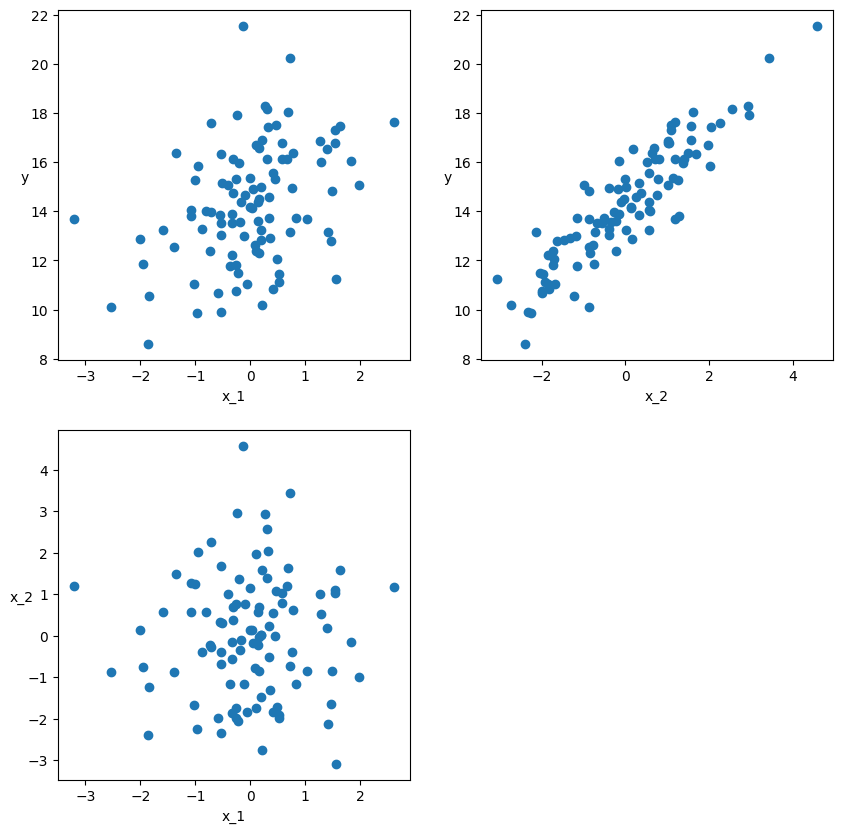

In [4]:
import matplotlib
matplotlib.pyplot.close()
scatter_plot(X_centered, y)

In [7]:
with pm.Model() as model_mlr:
 	α_tmp = pm.Normal('α_tmp', mu=0, sigma=10)
 	β = pm.Normal('β', mu=0, sigma=1, shape=2)
 	ϵ = pm.HalfCauchy('ϵ', 5)
 	μ = α_tmp + pm.math.dot(X_centered, β)
 	α = pm.Deterministic('α', α_tmp - pm.math.dot(X_mean, β))
 	y_pred = pm.Normal('y_pred', mu=μ, sigma=ϵ, observed=y)

In [8]:
with model_mlr:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_tmp, β, ϵ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


In [10]:
import arviz as az
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α_tmp,14.281,0.058,14.172,14.388,0.001,0.001,5858.0,3143.0,1.0
β[0],0.887,0.059,0.778,0.997,0.001,0.001,6884.0,3119.0,1.0
β[1],1.473,0.040,1.400,1.548,0.000,0.000,6977.0,3065.0,1.0
ϵ,0.579,0.042,0.496,0.655,0.001,0.000,4924.0,3320.0,1.0
α[0],2.694,0.596,1.562,3.785,0.007,0.005,6692.0,2949.0,1.0


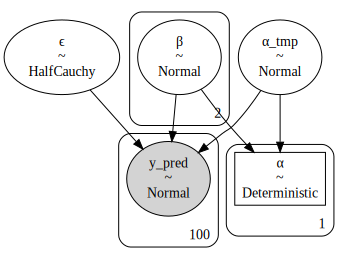

In [11]:
pm.model_to_graphviz(model_mlr)

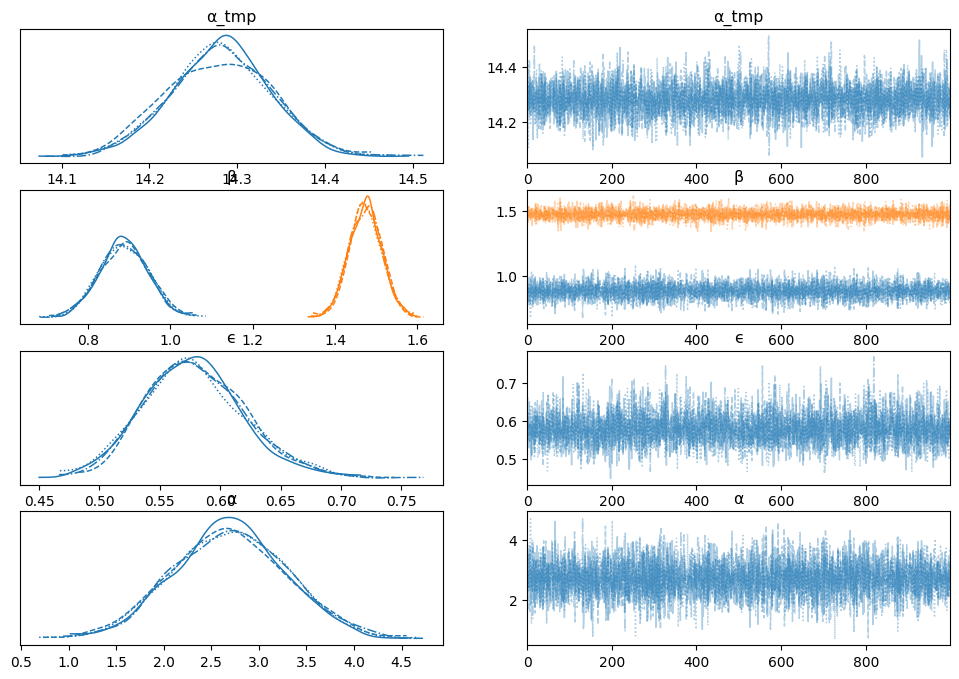

In [12]:
az.plot_trace(idata);

In [13]:
with model_mlr:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [y_pred]


In [14]:
idata.posterior_predictive

<xarray.Dataset>
Dimensions:       (chain: 4, draw: 1000, y_pred_dim_2: 100)
Coordinates:
  * chain         (chain) int32 0 1 2 3
  * draw          (draw) int32 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * y_pred_dim_2  (y_pred_dim_2) int32 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
Data variables:
    y_pred        (chain, draw, y_pred_dim_2) float64 16.83 10.95 ... 17.02
Attributes:
    created_at:                 2023-05-20T13:20:43.484142
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.1.2

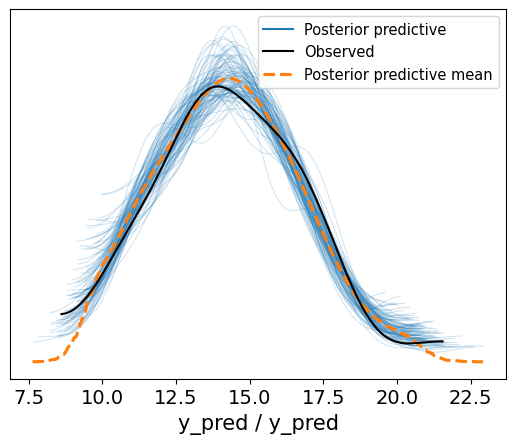

In [15]:
az.plot_ppc(idata, num_pp_samples=100);

In [16]:
with model_mlr:
    pm.compute_log_likelihood(idata)

In [17]:
loo_mlr = az.loo(idata)
loo_mlr

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -88.28     5.85
p_loo        3.41        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

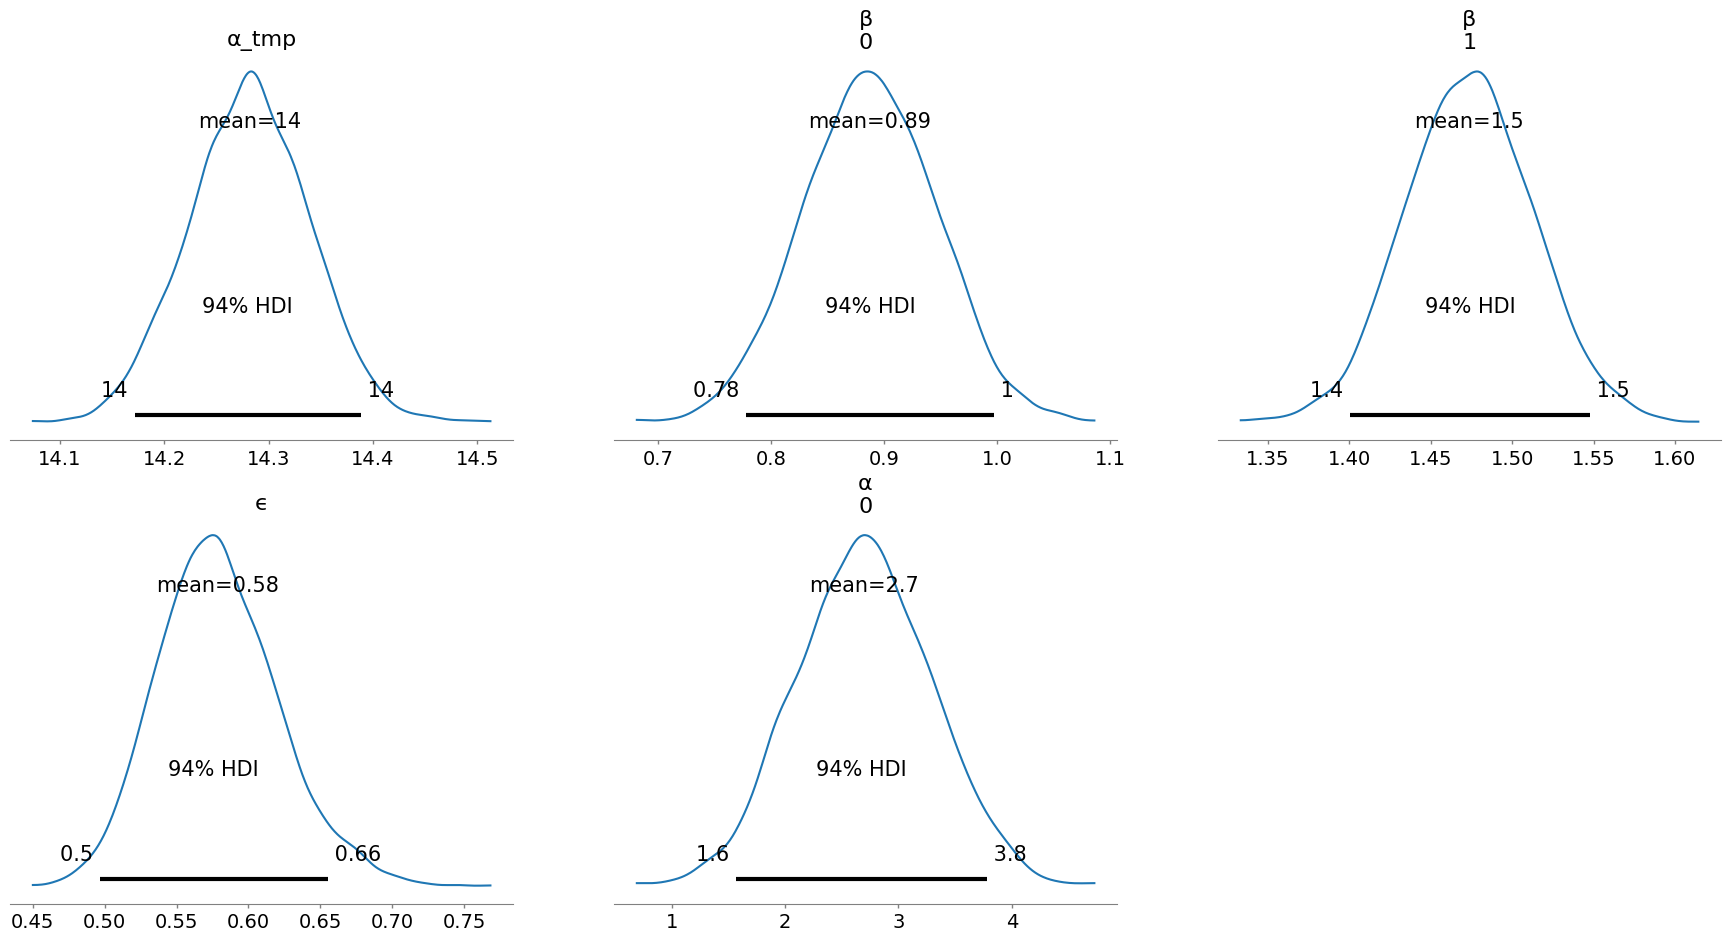

In [18]:
az.plot_posterior(idata);

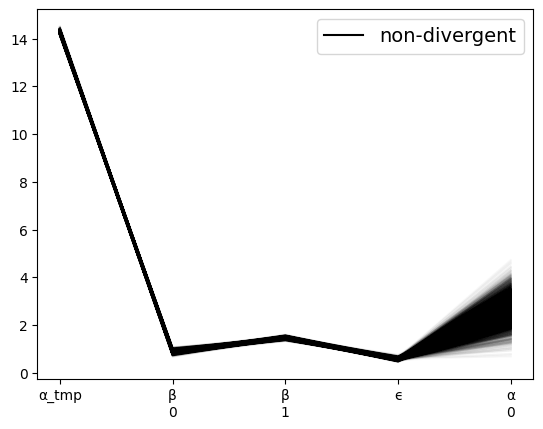

In [20]:
az.plot_parallel(idata);

In [19]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat May 20 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.11.0

numpy     : 1.23.5
pandas    : 1.5.3
pymc      : 5.1.2
arviz     : 0.15.1
matplotlib: 3.7.1
seaborn   : 0.12.2

Watermark: 2.3.1

